In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR
from functools import partial
import numpy as np
import os

In [2]:
'''caltech101:每张图像的尺寸约为 300x200 像素,加州理工学院 101 数据集总共包含 9146 张图像，分为 101 个不同的对象类别，以及一个额外的背景/杂波类别。
但是我从网上下载的数据caltech101集一共有102个分类，所以本次测试就对这102类图片进行分类
以test:train=1:9划分数据集
'''

batch_size=64#批次大小

#数据预处理，采用部分的图片增强技术
transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5520, 0.5336, 0.5050], std=[0.2353, 0.2345, 0.2372]),
    torchvision.transforms.RandomHorizontalFlip()
    ])

train_dataset=torchvision.datasets.ImageFolder(root='./data/caltech-101/train',transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root='./data/caltech-101/test',transform=transform)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [3]:
# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


class StdConv2d(nn.Conv2d):
    """Conv2d with Weight Standardization. Used for BiT ResNet-V2 models.
    Paper: `Micro-Batch Training with Batch-Channel Normalization and Weight Standardization` -
        https://arxiv.org/abs/1903.10520v2
    """
    def __init__(
            self, in_channel, out_channels, kernel_size, stride=1, padding=None,
            dilation=1, groups=1, bias=False, eps=1e-6):
        if padding is None:
            padding = get_padding(kernel_size, stride, dilation)
        super().__init__(
            in_channel, out_channels, kernel_size, stride=stride,
            padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.eps = eps

    def forward(self, x):
        weight = F.batch_norm(
            self.weight.reshape(1, self.out_channels, -1), None, None,
            training=True, momentum=0., eps=self.eps).reshape_as(self.weight)
        x = F.conv2d(x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Bottleneck(nn.Module): 
    
    # expansion是F(X)相对X维度拓展的倍数
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups
        # 此处width=out_channel

        self.conv1 = StdConv2d(in_channel, out_channels=width,kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.GroupNorm(num_channels=width,num_groups=groups)

        self.conv2 = StdConv2d(width, out_channels=width, groups=groups,kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.GroupNorm(num_channels=width,num_groups=groups)

        self.conv3 =StdConv2d(width, out_channels=out_channel * self.expansion,kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.GroupNorm(num_channels=out_channel * self.expansion,num_groups=groups)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,  # 使用的残差块类型
                 blocks_num,  # 每个卷积层，使用残差块的个数
                 groups=1,
                 width_per_group=64):

        super(ResNet, self).__init__()
    
        self.in_channel = 64  # 第一层卷积输出特征矩阵的深度，也是后面层输入特征矩阵的深度

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = StdConv2d(3, self.in_channel, kernel_size=7, stride=2,padding=3, bias=False)
        # self.std=nn.StdConv2d(conv1)
        self.bn1 = nn.GroupNorm(num_channels=self.in_channel,num_groups=groups)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None

        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))

        self.in_channel = channel * block.expansion
        
        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape : [16, 3, 224, 224]

        x = self.conv1(x)#[B, 64, 112, 112]
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.maxpool(x)#[B,64,56,56]
        
        x = self.layer1(x)#[B, 256, 56, 56]
        x = self.layer2(x)#[B, 512, 28, 28]
        x = self.layer3(x)#[B, 1024, 14, 14]
        
        return x

def resnet50():
    return ResNet(Bottleneck, [1, 1, 2])



In [4]:
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + F.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x,3))))

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob       = 1 - drop_prob
    shape           = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor   = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_() 
    output          = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    def __init__(self, input_shape=[224, 224], patch_size=16, in_chans=3, num_features=768, norm_layer=None, flatten=True):
        super().__init__()
        self.num_patches    = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
        self.flatten        = flatten

        self.proj = nn.Conv2d(in_chans, num_features, kernel_size=1, stride=1)
        self.norm = norm_layer(num_features) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2) 
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads  = num_heads
        self.scale      = (dim // num_heads) ** -0.5

        self.qkv        = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop  = nn.Dropout(attn_drop)
        self.proj       = nn.Linear(dim, dim)
        self.proj_drop  = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C     = x.shape
        qkv         = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v     = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=GELU, drop=0.):
        super().__init__()
        out_features    = out_features or in_features
        hidden_features = hidden_features or in_features
        drop_probs      = (drop, drop)

        self.fc1    = nn.Linear(in_features, hidden_features)
        self.act    = act_layer()
        self.drop1  = nn.Dropout(drop_probs[0])
        self.fc2    = nn.Linear(hidden_features, out_features)
        self.drop2  = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1      = norm_layer(dim)
        self.attn       = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2      = norm_layer(dim)
        self.mlp        = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.drop_path  = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
        
class VisionTransformer(nn.Module):
    def __init__(
            self, input_shape=[224, 224], patch_size=1, in_chans=1024, num_classes=102, num_features=768,
            depth=1, num_heads=8, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1,
            norm_layer=partial(nn.LayerNorm, eps=1e-6), act_layer=GELU
        ):
        super().__init__()

                
        self.res=resnet50()
        
        #   224, 224, 3 -> 196, 768
        self.patch_embed    = PatchEmbed(patch_size=patch_size, in_chans=in_chans, num_features=num_features)

        self.num_features   = num_features

        #   196, 768 -> 197, 768
        self.cls_token      = nn.Parameter(torch.zeros(1, 1, num_features))

        #   197, 768 -> 197, 768
        self.pos_embed      = nn.Parameter(torch.zeros(1, 196 + 1, num_features))
        self.pos_drop       = nn.Dropout(p=drop_rate)

        #   197, 768 -> 197, 768
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.Sequential(
            *[
                Block(
                    dim         = num_features, 
                    num_heads   = num_heads, 
                    mlp_ratio   = mlp_ratio, 
                    qkv_bias    = qkv_bias, 
                    drop        = drop_rate,
                    attn_drop   = attn_drop_rate, 
                    drop_path   = dpr[i], 
                    norm_layer  = norm_layer, 
                    act_layer   = act_layer
                )for i in range(depth)
            ]
        )
        
        self.norm = norm_layer(num_features)
        
        self.head = nn.Linear(num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        
        # x.shape： [B, 1024, 14, 14]
        
        x = self.patch_embed(x)#[B, 196, 768]
        
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) 
        
        x = torch.cat((cls_token, x), dim=1)#[B, 197, 768]
        
        x = self.pos_drop(x + self.pos_embed)#[B, 197, 768]
        
        x = self.blocks(x)#[B, 197, 768]
        
        x = self.norm(x)#[B, 197, 768]
        
        return x[:, 0]

    def forward(self, x):
        
        #x.shape: [B, 3, 224, 224]
        
        x=self.res(x)#[B, 1024, 14, 14]

        x = self.forward_features(x)#[B, 768]
        
        x = self.head(x)#[B, 102]

        return x

    
def vit(num_classes=102):
    model = VisionTransformer()
    return model


In [5]:
model=vit()

In [6]:
#用gpu训练
device = torch.device("cuda")
model = model.to(device)

In [7]:
#定义损失函数（采用交叉熵损失函数）
criterion =nn.CrossEntropyLoss()

#定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006,weight_decay=0.0006)


#定义学习率调整器
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)#54%

#损失
train_loss_list=[]
test_loss_list=[]
#准确
train_accuracy_list=[]
test_accuracy_list=[]

In [8]:
#训练
def train(epoch):
    model.train(True)
    train_loss=0
    accuracy=0
    correct=0
    
    for idx,(data,target) in enumerate(train_loader):
        
        data,target=data.to(device),target.to(device)
        
        optimizer.zero_grad()#梯度初始化，清除之前的梯度
        
        output = model(data)
        
        loss = criterion(output,target)#对数似然损失
        
        loss.backward()#计算当前梯度，反向传播

        optimizer.step()#更新参数

        train_loss+=loss.item()
        
        pred=output.data.max(1,keepdim=True)[1]#找出概率最大值所对应的类别
            
        correct+=pred.eq(target.data.view_as(pred)).sum()#统计正确预测的数量

    train_loss/=len(train_loader.dataset)
    
    accuracy=correct.item()/len(train_loader.dataset)*100
    
    print( 'Epoch:{} \nTrain: loss:{:.8f},accuracy:{}/{} ={:.2f}%'.format (epoch+1,train_loss,correct,len(train_loader.dataset),accuracy))
    
    train_accuracy_list.append(accuracy)
    train_loss_list.append(train_loss)
    

In [9]:
#测试评估
def test():
    test_loss=0
    accuracy=0
    correct=0;
    
    #开启评估模式
    model.eval()

    with torch.no_grad():
        for idx,(data,target) in enumerate(test_loader):
            
            data,target=data.to(device),target.to(device)
            
            output=model(data)
             
            test_loss+=criterion(output,target).item()
            
            pred=output.data.max(1,keepdim=True)[1]#找出概率最大值所对应的类别
            
            correct+=pred.eq(target.data.view_as(pred)).sum()#统计正确预测的数量
            
    test_loss/=len(test_loader.dataset)

    accuracy=correct.item()/len(test_loader.dataset)*100
            
    print("Test: loss:{:.8f},accuracy:{}/{} ={:.2f}%\n".format(test_loss,correct,len(test_loader.dataset),accuracy))
                
    test_accuracy_list.append(accuracy)
    test_loss_list.append(test_loss)
    

In [10]:
#画图
def fig():
    fig, ax1 = plt.subplots()

    # 绘制第一条曲线（Train Loss）在左侧 y 轴上
    ax1.plot(train_loss_list, label='Train Loss', color='green')
    ax1.plot(test_loss_list, label='Test Loss', color='yellow')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='green')
    
    # 创建第二个 y 轴，并绘制第二条曲线（Accuracy）在右侧 y 轴上
    ax2 = ax1.twinx()
    ax2.plot(train_accuracy_list, label='Train Accuracy', color='blue')
    ax2.plot(test_accuracy_list, label='Test Accuracy', color='red')
    ax2.set_ylabel('Accuracy(%)', color='red')
    
    handle1, label1 = ax1.get_legend_handles_labels()
    handle2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(handle1 + handle2, label1 + label2,loc='upper left') 

    plt.show()



/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:1 
Train: loss:0.06097479,accuracy:1603/8279 =19.36%
Test: loss:0.04964147,accuracy:232/866 =26.79%

Epoch:2 
Train: loss:0.05122026,accuracy:2261/8279 =27.31%
Test: loss:0.04528416,accuracy:246/866 =28.41%

Epoch:3 
Train: loss:0.04454775,accuracy:2716/8279 =32.81%
Test: loss:0.03923946,accuracy:313/866 =36.14%

Epoch:4 
Train: loss:0.04028909,accuracy:3087/8279 =37.29%
Test: loss:0.03629032,accuracy:335/866 =38.68%

Epoch:5 
Train: loss:0.03501598,accuracy:3600/8279 =43.48%
Test: loss:0.03290306,accuracy:392/866 =45.27%

Epoch:6 
Train: loss:0.03186460,accuracy:3990/8279 =48.19%
Test: loss:0.03030038,accuracy:410/866 =47.34%

Epoch:7 
Train: loss:0.02789127,accuracy:4432/8279 =53.53%
Test: loss:0.02816485,accuracy:443/866 =51.15%

Epoch:8 
Train: loss:0.02587798,accuracy:4704/8279 =56.82%
Test: loss:0.02639833,accuracy:452/866 =52.19%

Epoch:9 
Train: loss:0.02307489,accuracy:5049/8279 =60.99%
Test: loss:0.02618513,accuracy:465/866 =53.70%

Epoch:10 
Train: loss:0.02138892,accu

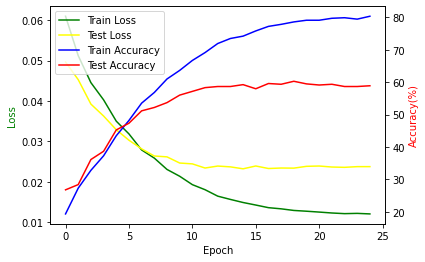

In [11]:
#训练次数
epoch=25

for i in range(epoch):
    train(i)
    scheduler.step()#更新学习率
    test()



fig()

In [ ]:
#保存训练好的模型
# path='./keep_model'

# model_path = os.path.join(path, "model"+".bin")
   
# torch.save(model.state_dict(),model_path)

In [12]:
torch.cuda.empty_cache()